In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURATION ---
# Adjust this path if running from a different location
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSAC")

def parse_xml_classes(xml_path):
    """
    Parses an Aperio ImageScope XML to find unique class names.
    Returns a set of class names found in 'Annotation' tags.
    """
    classes_found = set()
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        # In MoNuSAC, the class name is usually in the 'Name' attribute of 'Annotation'
        for annotation in root.findall("Annotation"):
            name = annotation.get("Name")
            if name:
                classes_found.add(name.strip())
    except Exception as e:
        print(f"⚠️ Error parsing {xml_path.name}: {e}")
    return classes_found

def investigate_dataset():
    data_log = []
    
    # MoNuSAC structure: Base -> Split (train/test) -> PatientID -> Files
    splits = ['train', 'test']
    
    print(f"🔍 Scanning MoNuSAC at: {BASE_PATH}")
    
    for split in splits:
        split_dir = BASE_PATH / split
        if not split_dir.exists():
            print(f"❌ Split directory not found: {split_dir}")
            continue
            
        # Walk through patient folders
        # split_dir.iterdir() gives us PatientIDs like 'TCGA-55-1594...'
        patient_folders = [p for p in split_dir.iterdir() if p.is_dir()]
        
        for patient_path in tqdm(patient_folders, desc=f"Scanning {split}"):
            # Find all .tif files (assuming these are the ROIs)
            tif_files = sorted(list(patient_path.glob("*.tif")))
            
            for img_path in tif_files:
                # Construct corresponding XML path
                # usually same name but .xml extension
                xml_path = img_path.with_suffix(".xml")
                
                # 1. Check Image Dimensions
                img = cv2.imread(str(img_path))
                if img is None:
                    h, w = 0, 0
                    valid_img = False
                else:
                    h, w = img.shape[:2]
                    valid_img = True
                
                # 2. Check XML and Classes
                has_xml = xml_path.exists()
                classes = set()
                num_regions = 0
                
                if has_xml:
                    classes = parse_xml_classes(xml_path)
                    # Count total regions just for stats
                    try:
                        tree = ET.parse(xml_path)
                        num_regions = len(tree.findall(".//Region"))
                    except:
                        pass

                data_log.append({
                    'split': split,
                    'patient_id': patient_path.name,
                    'filename': img_path.name,
                    'width': w,
                    'height': h,
                    'has_xml': has_xml,
                    'classes': list(classes),
                    'num_regions': num_regions
                })

    # --- SUMMARY ---
    df = pd.DataFrame(data_log)
    
    if df.empty:
        print("❌ No data found.")
        return

    print("\n" + "="*40)
    print("📊 DATASET INVESTIGATION REPORT")
    print("="*40)
    
    # 1. Image Dimensions
    print(f"\nTotal Images: {len(df)}")
    print(f"Min Size: {df['width'].min()}x{df['height'].min()}")
    print(f"Max Size: {df['width'].max()}x{df['height'].max()}")
    print(f"Images != 512x512: {len(df[(df['width'] != 512) | (df['height'] != 512)])}")
    
    # 2. Missing Annotations
    missing_xml = df[~df['has_xml']]
    if not missing_xml.empty:
        print(f"\n⚠️ Files missing XML ({len(missing_xml)}):")
        print(missing_xml['filename'].head().tolist())
    else:
        print("\n✅ All images have corresponding XML files.")

    # 3. Class Analysis
    # Flatten the list of classes to find all unique labels across the dataset
    all_classes = set()
    for c_list in df['classes']:
        all_classes.update(c_list)
        
    print(f"\n🏷️  Unique Classes Found in XMLs: {sorted(list(all_classes))}")
    
    # 4. Show a sample row
    print("\n📝 Sample Entry:")
    print(df.iloc[0])

if __name__ == "__main__":
    investigate_dataset()

🔍 Scanning MoNuSAC at: /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSAC


Scanning test: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


📊 DATASET INVESTIGATION REPORT

Total Images: 294
Min Size: 35x33
Max Size: 2162x2500
Images != 512x512: 284

✅ All images have corresponding XML files.

🏷️  Unique Classes Found in XMLs: ['Epithelial', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Lymphocytes', 'Macrophages', 'Neutrophils']

📝 Sample Entry:
split                                    train
patient_id             TCGA-55-1594-01Z-00-DX1
filename       TCGA-55-1594-01Z-00-DX1_001.tif
width                                     1024
height                                    1024
has_xml                                   True
classes                                     []
num_regions                                251
Name: 0, dtype: object


In [1]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import xml.etree.ElementTree as ET
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import numcodecs
import random

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSAC")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monusac/zarr_data")

# MoNuSAC allows multiple classes, but we are doing Instance Segmentation (Nuclei vs Bg)
# We filter for these specific nuclear types:
VALID_CLASSES = {'Epithelial', 'Lymphocytes', 'Macrophages', 'Neutrophils', 'Layer 1', 'Layer1'}

TILE_SIZE = 512
VAL_SPLIT = 0.10  # 10% for validation
NUM_WORKERS = 16
SEED = 42

cv2.setNumThreads(0)
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------
# 1. Helper: Parse MoNuSAC XML to Single Instance Mask
# ---------------------------------------------------------------------
def xml_to_instance_mask(xml_path, shape):
    """
    Parses Aperio XML to generate a single Instance Mask.
    Merges valid classes into unique instance IDs (1, 2, 3...).
    """
    h, w = shape[:2]
    inst_map = np.zeros((h, w), dtype=np.int32)
    
    if not xml_path.exists():
        return inst_map

    try:
        tree = ET.parse(str(xml_path))
        root = tree.getroot()
        
        inst_id_counter = 1
        
        # Iterate over Annotations
        for annotation in root.findall("Annotation"):
            name = annotation.get("Name", "").strip()
            
            # Filter by class name if strictly required
            # Note: Some MoNuSAC XMLs name layers differently, but usually these are the valid ones
            if name not in VALID_CLASSES and "Region" not in name:
                 # Check if it's one of the target classes
                 pass 
            
            # Iterate over Regions (Nuclei)
            regions = annotation.findall(".//Region")
            for region in regions:
                vertices = []
                for vert in region.findall(".//Vertex"):
                    vx = float(vert.get("X"))
                    vy = float(vert.get("Y"))
                    vertices.append([vx, vy])
                
                if len(vertices) > 2:
                    pts = np.array(vertices, dtype=np.int32)
                    # Draw Instance (Unique ID)
                    cv2.fillPoly(inst_map, [pts], int(inst_id_counter))
                    inst_id_counter += 1
                    
    except Exception as e:
        print(f"⚠️ XML Error {xml_path.name}: {e}")

    return inst_map

# ---------------------------------------------------------------------
# 2. Helper: Tile/Pad Logic
# ---------------------------------------------------------------------
def get_tile_coordinates(dim_size, tile_size):
    """
    Calculates start/end coordinates with overlap logic to ensure full coverage.
    """
    if dim_size <= tile_size:
        return [(0, tile_size)]

    coords = []
    cursor = 0
    while cursor + tile_size <= dim_size:
        coords.append((cursor, cursor + tile_size))
        cursor += tile_size # No overlap stride, just distinct tiles if possible? 
        # Actually, let's do distinct tiles (stride = tile_size) for training data to avoid duplicates
        # But if we want overlap to cover edges, we shift the last one.
    
    # Handle remainder by forcing last tile to end at image edge
    if cursor < dim_size:
        last_start = dim_size - tile_size
        if not coords or coords[-1][0] != last_start:
            coords.append((last_start, dim_size))
            
    return coords

# ---------------------------------------------------------------------
# 3. Process Single Image (Worker)
# ---------------------------------------------------------------------
def process_single_image(args):
    """
    Worker function to process one slide/ROI.
    """
    img_path, output_dir, split_tag = args
    slide_name = img_path.stem
    slide_out_dir = output_dir / slide_name
    
    try:
        # A. Load Image
        img = cv2.imread(str(img_path))
        if img is None:
            return 0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # B. Load/Parse XML
        # MoNuSAC: XML usually has same name as image
        xml_path = img_path.with_suffix(".xml")
        h_raw, w_raw = img.shape[:2]
        
        inst_mask = xml_to_instance_mask(xml_path, (h_raw, w_raw))

        # C. Handle Padding for Small Images
        pad_h = max(0, TILE_SIZE - h_raw)
        pad_w = max(0, TILE_SIZE - w_raw)
        
        if pad_h > 0 or pad_w > 0:
            img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            inst_mask = cv2.copyMakeBorder(inst_mask, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            
        h, w = img.shape[:2]

        # D. Generate Tile Coordinates
        h_coords = get_tile_coordinates(h, TILE_SIZE)
        w_coords = get_tile_coordinates(w, TILE_SIZE)

        img_stack = []
        mask_stack = []
        metadata_list = []

        # E. Extract Tiles
        for r_idx, (y_start, y_end) in enumerate(h_coords):
            for c_idx, (x_start, x_end) in enumerate(w_coords):
                
                img_crop = img[y_start:y_end, x_start:x_end, :]
                mask_crop = inst_mask[y_start:y_end, x_start:x_end]

                if img_crop.shape[0] != TILE_SIZE or img_crop.shape[1] != TILE_SIZE:
                    continue

                # Metadata
                # Count nuclei in this patch
                uniques = np.unique(mask_crop)
                n_nuclei = len(uniques) - (1 if 0 in uniques else 0)

                img_stack.append(img_crop)
                mask_stack.append(mask_crop)
                
                metadata_list.append({
                    'original_file': img_path.name,
                    'patient_id': img_path.parent.name, # MoNuSAC often has PatientID folder
                    'split': split_tag,
                    'tile_y': r_idx,
                    'tile_x': c_idx,
                    'y_start': y_start,
                    'x_start': x_start,
                    'num_nuclei': n_nuclei
                })

        if not img_stack:
            return 0

        # F. Save to Zarr
        if slide_out_dir.exists():
            import shutil
            shutil.rmtree(slide_out_dir)
        os.makedirs(slide_out_dir, exist_ok=True)
        
        compressor = numcodecs.Blosc(cname='zstd', clevel=3)

        all_imgs = np.stack(img_stack, axis=0)
        all_masks = np.stack(mask_stack, axis=0)

        z_img = zarr.open_array(str(slide_out_dir / 'images.zarr'), mode='w', shape=all_imgs.shape, chunks=(1, TILE_SIZE, TILE_SIZE, 3), dtype='uint8', compressor=compressor)
        z_img[:] = all_imgs

        z_mask = zarr.open_array(str(slide_out_dir / 'nuclei_masks.zarr'), mode='w', shape=all_masks.shape, chunks=(1, TILE_SIZE, TILE_SIZE), dtype='int32', compressor=compressor)
        z_mask[:] = all_masks

        pd.DataFrame(metadata_list).to_csv(slide_out_dir / 'metadata.csv', index=False)
        
        return len(img_stack)

    except Exception as e:
        print(f"❌ Error processing {img_path.name}: {e}")
        return 0

# ---------------------------------------------------------------------
# 4. Main Processing
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("="*60)
    print("🔬 MoNuSAC Split: Train(90%) / Val(10%) | Test(Keep As Is)")
    print("="*60)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    tasks = []

    # --- 1. Gather TEST Files (Keep Separate) ---
    test_dir = BASE_PATH / "test" # Check if folder is 'Test' or 'test'
    if not test_dir.exists(): test_dir = BASE_PATH / "Test"
    
    if test_dir.exists():
        # MoNuSAC structure: Test/PatientID/image.tif
        test_files = sorted(list(test_dir.glob("*/*.tif")) + list(test_dir.glob("*.tif")))
        print(f"\n📂 Found {len(test_files)} Test slides.")
        
        out_test = OUTPUT_BASE / "monusac_test"
        for f in test_files:
            tasks.append((f, out_test, "test"))
    else:
        print("⚠️ Test folder not found.")

    # --- 2. Gather TRAIN Files & Split ---
    train_dir = BASE_PATH / "train" # Check casing
    if not train_dir.exists(): train_dir = BASE_PATH / "Training Data"
    
    if train_dir.exists():
        # MoNuSAC structure: Training Data/PatientID/image.tif
        train_files = sorted(list(train_dir.glob("*/*.tif")) + list(train_dir.glob("*.tif")))
        print(f"\n📂 Found {len(train_files)} Source Train slides.")
        
        # SHUFFLE & SPLIT
        random.shuffle(train_files)
        
        n_val = int(len(train_files) * VAL_SPLIT)
        if n_val == 0 and len(train_files) > 1: n_val = 1
        
        val_files = train_files[:n_val]
        train_subset = train_files[n_val:]
        
        print(f"   📊 Split Result:")
        print(f"      Training:   {len(train_subset)} slides")
        print(f"      Validation: {len(val_files)} slides")
        
        out_train = OUTPUT_BASE / "monusac_train"
        out_val = OUTPUT_BASE / "monusac_val"
        
        for f in train_subset:
            tasks.append((f, out_train, "train"))
            
        for f in val_files:
            tasks.append((f, out_val, "val"))
            
    else:
        print("⚠️ Train folder not found.")

    if not tasks:
        print("❌ No files found to process.")
        exit()

    # --- 3. Execute ---
    print(f"\n🚀 Processing {len(tasks)} slides with {NUM_WORKERS} workers...")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(
            executor.map(process_single_image, tasks),
            total=len(tasks),
            desc="Processing"
        ))

    total_patches = sum(results)
    print(f"\n✅ DONE. Total patches generated: {total_patches}")

🔬 MoNuSAC Split: Train(90%) / Val(10%) | Test(Keep As Is)

📂 Found 85 Test slides.

📂 Found 209 Source Train slides.
   📊 Split Result:
      Training:   189 slides
      Validation: 20 slides

🚀 Processing 294 slides with 16 workers...


Processing: 100%|██████████| 294/294 [00:09<00:00, 30.75it/s]


✅ DONE. Total patches generated: 903


🔍 Inspecting Slide: TCGA-G7-A8LD-01Z-00-DX1_9
📂 Location: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monusac/zarr_data/monusac_train/TCGA-G7-A8LD-01Z-00-DX1_9
   Tiles available: 2
   Selected Tile Index: 1
   Image Shape: (512, 512, 3), Mask Shape: (512, 512)
   Unique Instance IDs in mask: 5

✅ Visualization saved to: monusac_visualization_check.png
   (Check this file to verify alignment)


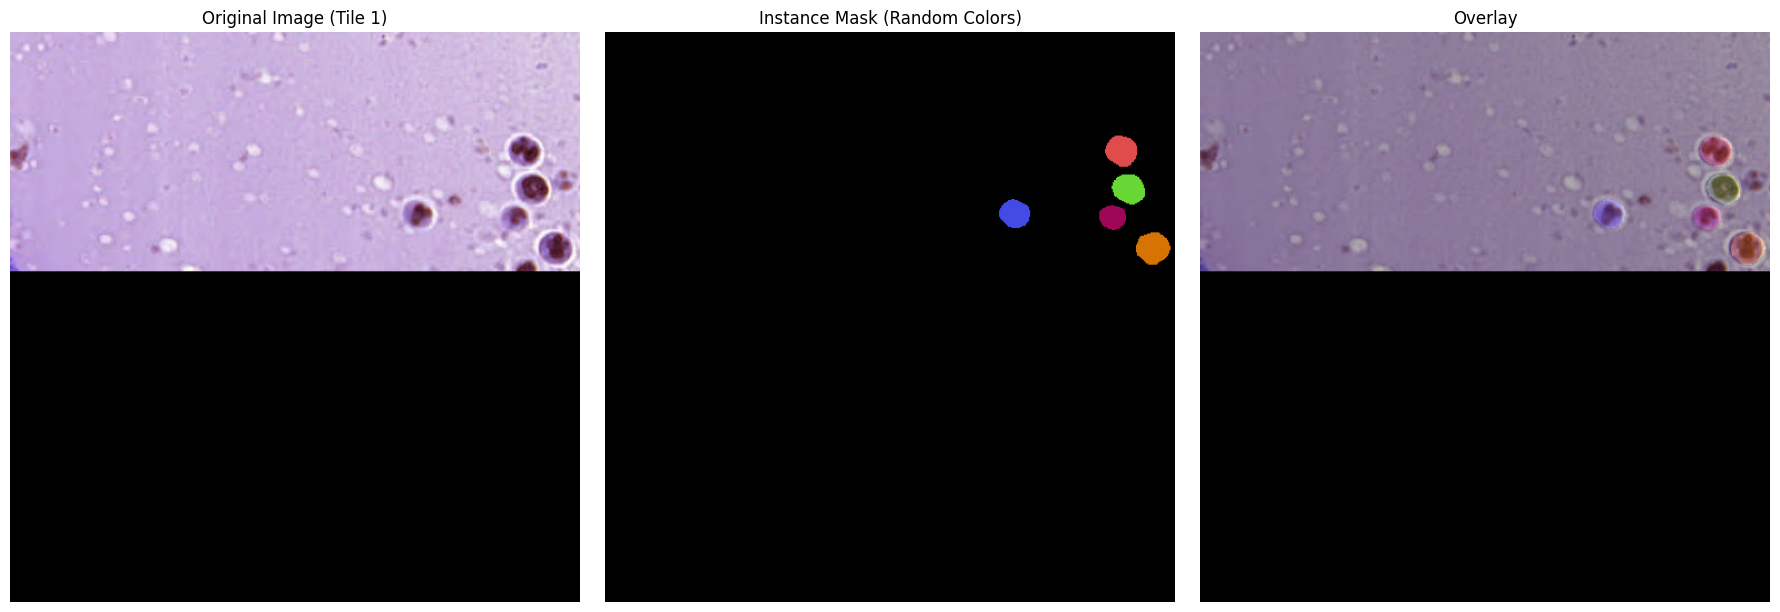

In [31]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
import cv2

# --- CONFIGURATION ---
# Path to the Zarr data you just created
DATA_ROOT = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monusac/zarr_data")

def visualize_random_sample():
    # 1. Find all available slides in train and test
    slides = []
    for split in ["monusac_train", "monusac_test"]:
        split_path = DATA_ROOT / split
        if split_path.exists():
            slides.extend(list(split_path.glob("*")))
    
    if not slides:
        print("❌ No data found. Check your path.")
        return

    # 2. Pick a random slide
    random_slide = random.choice(slides)
    print(f"🔍 Inspecting Slide: {random_slide.name}")
    print(f"📂 Location: {random_slide}")

    try:
        # 3. Open Zarr arrays
        z_img = zarr.open(str(random_slide / "images.zarr"), mode='r')
        z_mask = zarr.open(str(random_slide / "nuclei_masks.zarr"), mode='r')

        num_tiles = z_img.shape[0]
        print(f"   Tiles available: {num_tiles}")

        if num_tiles == 0:
            print("⚠️ Slide has 0 tiles.")
            return

        # 4. Pick a random tile index
        idx = random.randint(0, num_tiles - 1)
        
        # Load data
        img = z_img[idx]
        mask = z_mask[idx]

        print(f"   Selected Tile Index: {idx}")
        print(f"   Image Shape: {img.shape}, Mask Shape: {mask.shape}")
        print(f"   Unique Instance IDs in mask: {len(np.unique(mask)) - 1}")

        # 5. Visualization
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Original Image
        ax[0].imshow(img)
        ax[0].set_title(f"Original Image (Tile {idx})")
        ax[0].axis("off")

        # Instance Mask (Colored) 
        # Create a colored visualization for instances
        inst_viz = np.zeros_like(img)
        unique_ids = np.unique(mask)
        for uid in unique_ids:
            if uid == 0: continue
            # Generate random color for this ID
            color = np.random.randint(0, 255, size=3).tolist()
            inst_viz[mask == uid] = color
            
        ax[1].imshow(inst_viz)
        ax[1].set_title("Instance Mask (Random Colors)")
        ax[1].axis("off")

        # Overlay
        overlay = cv2.addWeighted(img, 0.7, inst_viz, 0.3, 0)
        ax[2].imshow(overlay)
        ax[2].set_title("Overlay")
        ax[2].axis("off")

        plt.tight_layout()
        
        # Save plot to check it
        save_path = "monusac_visualization_check.png"
        plt.savefig(save_path)
        print(f"\n✅ Visualization saved to: {save_path}")
        print("   (Check this file to verify alignment)")

    except Exception as e:
        print(f"❌ Error visualizing: {e}")

if __name__ == "__main__":
    visualize_random_sample()